# Linear Regression
### Christian Igel, 2024


I took inspiration from https://github.com/tirthajyoti/Interactive_Machine_Learning by Tirthajyoti Sarkar.
I am happy for suggestions to improve the notebook.

In [1]:
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual, fixed
import ipywidgets as widgets
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts,bm}')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV, Lasso
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

## Linear Regression and Regularization

### Function to fit
Just some artificial function with Gaussian noise.

In [2]:
def func_gen(N_samples, noise_sd, resolution=500):
    """Data generator.
    Parameters:
        N_samples: data set size
        noise_sd: std. deviation of additive zero mean Gaussin noise
        resolution: number of equally spaced points for plotting noise-free function
    Returns: 
        x, y: inputs and (noisy) targets
        x_lin, y_lin: equally spaced inputs and their noise-free function values 
        x_min, x_max: input domain
    """    
    def func(x):
        return 2*x -0.6*x**2 + 0.2*x**3+12 * np.sin(x)
    x_min = -5
    x_max = 5
    x_lin = np.linspace(x_min, x_max, resolution)  # equally spaced points
    x = np.random.choice(x_lin, size=N_samples)  # random points
    y = func(x)
    y_lin = func(x_lin)
    y = y + np.random.normal(scale=noise_sd, size=N_samples)
    plt.figure(figsize=(8,5))
    plt.plot(x_lin,y_lin,c='C1',lw=2)
    plt.scatter(x,y,c='C0',s=60)
    plt.grid(True)
    plt.show()
    return (x.reshape(-1,1), y, x_lin, y_lin, x_min, x_max)

### Call the interactive widget with the data generating function

In [3]:
p = interactive(func_gen, 
                N_samples=widgets.IntSlider(min=10,max=200.,step=10,continuous_update=False,value=100),
                noise_sd=widgets.FloatSlider(min=0.,max=10.,step=0.5,continuous_update=False,value=2.5),resolution=fixed(500))
display(p)

interactive(children=(IntSlider(value=100, continuous_update=False, description='N_samples', max=200, min=10, …

In [4]:
# Extract the data from the plot
x, y, x_lin, y_lin, x_min, x_max = p.result

### Linear models encapsulated in a function 

In [5]:
lasso_eps = 0.01
lasso_nalpha = 20  # alpha = lambda (= gamma)
lasso_iter = 100000  # maximum number of iterative LASSO optimization steps   
lasso_tol = 0.0001  # controls a stopping criterion of the LASSO optimization

def func_fit(model_type, test_size, degree, alpha, resolution=500):
    """Fits model to data.
    Parameters:
        model_type: 'Linear regression', 'Ridge', or 'LASSO'
        test_size: percentage of test data
        degree: degree of polynomial
        alpha: natural logarithm of regularization parameter
        resolution: number of equally spaced points for plotting 
    Returns: 
        train_score, test_score: training and test score (R2)
        model, model_type: model and given model type
    """    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=55)
    
    if (model_type=='Linear regression'):
        model = make_pipeline(PolynomialFeatures(degree,interaction_only=False), 
                              LinearRegression(fit_intercept=False))
    if (model_type=='Ridge'):    
        model = make_pipeline(PolynomialFeatures(degree,interaction_only=False), 
                              Ridge(alpha=np.exp(alpha), fit_intercept=False, solver='svd'))
    if (model_type=='LASSO'):    
        model = make_pipeline(PolynomialFeatures(degree,interaction_only=False), 
                              Lasso(alpha=np.exp(alpha), fit_intercept=False, max_iter=lasso_iter, warm_start=True, positive=False, selection='random'))
        
    scaler = StandardScaler()
    scaler.fit_transform(X_train)
    scaler.transform(X_test)
    
    model.fit(X_train,y_train)
    
    train_pred = np.array(model.predict(X_train))
    train_score = model.score(X_train,y_train)
    
    test_pred = np.array(model.predict(X_test))
    test_score = model.score(X_test, y_test)
    
    X_grid = np.linspace(x_min, x_max, resolution).reshape(-1,1)
    y_grid = np.array(model.predict(X_grid))
    
    plt.figure(figsize=(14,6))
    
    plt.subplot(1,2,2)
    plt.title(r"Test $R^2$ score: %.3f"%(test_score))
    plt.xlabel(r"$x$", fontsize=14)
    plt.ylabel(r"$y$", fontsize=14)
    plt.scatter(X_test, y_test, c='C0', s=60, label='Actual test values')
    plt.scatter(X_test, test_pred,c='C1', s=40, label='Predicted values')
    plt.plot(X_grid, y_grid,label="Model", c='C1', lw=2)
    y_min = np.min([y_test.min(), test_pred.min()])
    y_max = np.min([y_test.max(), test_pred.max()])
    plt.ylim([np.amin([1.1*y_min, 0.9*y_min]), np.amax([1.1*y_max, 0.9*y_max])])
    plt.xlim(np.min(X_grid), np.max(X_grid))
    plt.plot(x_lin, y_lin, label="Function w/o noise", c='red', lw=2, alpha=0.5)
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1,2,1)
    plt.title(r"Training $R^2$ score: %.3f"%(train_score))
    plt.xlabel(r"$x$", fontsize=14)
    plt.ylabel(r"$y$", fontsize=14)
    plt.scatter(X_train, y_train, c='C0', label="Traning data", s=60)
    plt.scatter(X_train, train_pred, c='C1', label="Fitted values", s=40)
    plt.plot(X_grid, y_grid, label="Model", c='C1', lw=2)
    y_min = np.min([y_train.min(), train_pred.min()])
    y_max = np.min([y_train.max(), train_pred.max()])
    plt.ylim([np.amin([1.1*y_min, 0.9*y_min]), np.amax([1.1*y_max, 0.9*y_max])])
    plt.xlim(np.min(X_grid), np.max(X_grid))
    plt.plot(x_lin, y_lin, label="Function w/o noise", c='red', lw=2, alpha=0.5)
    plt.grid(True)
    plt.legend()
    #plt.savefig("interactiveLinearRegression"+str(degree)+".pdf",bbox_inches='tight')
    plt.show()
       
    return (train_score, test_score, model, model_type)    

### Run the encapsulated ML function 
The score is the coefficient of determination $R^2$, the closer to 1 the better (see assignment).
The regularization parameter is referred to as $\lambda$ (the parameter of the Python function is called `alpha` and in the literature $\gamma$ is often used). For some setting, the optimization algorithms do not converge (simply ignore the warning).

In [6]:
style = {'description_width': 'initial'}
# Continuous_update = False for IntSlider control to stop continuous model evaluation while the slider is being dragged
m = interactive(func_fit,model_type=widgets.RadioButtons(options=['Linear regression','LASSO', 'Ridge'],
                                                         description = "Choose Model",style=style,
                                                         layout=Layout(width='250px')),
                test_size=widgets.Dropdown(options={"10% of data":0.1,"25% of data":0.25, "50% of data":0.5, "75% of data":0.75},
                                           description="Test set size",style=style, value=0.5),
                degree=widgets.IntSlider(min=1, max=40, step=1, description= r'Polynomial degree',
                                       style=style, continuous_update=False),
                alpha=widgets.FloatSlider(min=-15, max=10, step=1, description= r'$\ln\lambda$',
                                       style=style, continuous_update=False),
                resolution=fixed(500))

# Display the control
display(m)

interactive(children=(RadioButtons(description='Choose Model', layout=Layout(width='250px'), options=('Linear …

### Visualize coefficients

[-4.16750862  4.70642955]


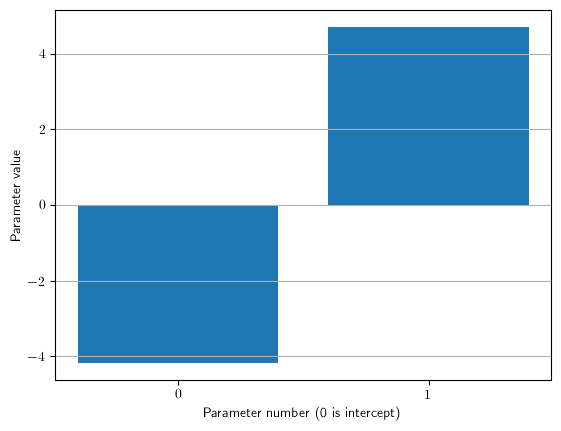

In [7]:
e_train, e_text, model, model_type = m.result
print(model[1].coef_)

plt.xlabel('Parameter number (0 is intercept)')
plt.ylabel('Parameter value')
plt.grid(axis='y')
plt.xticks(np.arange(0, len(model[1].coef_)))
plt.bar(np.arange(0, len(model[1].coef_)), model[1].coef_);

### Cross-validation
Set parameters and parameter ranges, which should depend on whether the model type is LASSO or Ridge:

In [8]:
if model_type=='Linear regression':  # our linear regression has no hyperparameters
    model_type = 'Ridge'
test_size = .30  # percentage of data used as (external) test set
log_lambda_range = np.arange(-5,3)  # range of regularization parameters on logarithmic scale
degree_range = np.arange(1,6)  # range of degrees for polynomial representation
folds = 5  # number of folds for cross-validation

Do the cross-validation. 

In [9]:
best_degree = 0
best_log_lambda = 0
best_cv_score = 0

# (X_train, y_train) are used for cross-validation
# (X_test, y_test) are used for testing the model and is not used in training and model selection (cross-validation)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size,random_state=55)

scaler = StandardScaler()
kf = KFold(n_splits=folds)

for degree in degree_range:  # loop over degrees
    # Compute polynomial features including constant (bias) feature (include_bias=True)
    poly = PolynomialFeatures(degree=degree, interaction_only=False)
    X_train_poly = poly.fit_transform(X_train)
    for log_lambda in log_lambda_range:  # loop of regularization parameters
        cv_score = 0
        for train_i, val_i in kf.split(X_train_poly):  # loop over cross-validation folds
            X_train_fold, y_train_fold = X_train_poly[train_i], y_train[train_i]
            X_val_fold, y_val_fold = X_train_poly[val_i], y_train[val_i]
    
            # Only the current training data is used for scaling
            scaler.fit_transform(X_train_fold)
            scaler.transform(X_val_fold)
     
            # Features include constant (bias), so we need not fit an extra intercept 
            if (model_type=='Ridge'):
                model = Ridge(alpha=np.exp(log_lambda), fit_intercept=False)
            elif (model_type=='LASSO'):
                model = Lasso(alpha=np.exp(log_lambda), fit_intercept=False, max_iter=lasso_iter)
            else:
                print("unknown model: only LASSO and Ridge are supported")
                assert(False)
            model.fit(X_train_fold, y_train_fold)
    
            score = model.score(X_val_fold, y_val_fold)
            cv_score += score
        if cv_score > best_cv_score:  # found new best score? 
            best_cv_score = cv_score
            best_degree = degree
            best_log_lambda = log_lambda

print("Best average CV score:", best_cv_score / folds)
print(model_type, " degree:", best_degree, "log. lambda:", best_log_lambda)

# After cross-validation, the model 
#   is trained with the best parameters on the full training data set and 
#   is evaluated on the external test data
poly = PolynomialFeatures(degree=best_degree, interaction_only=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.transform(X_test)
scaler.fit_transform(X_train_poly)
scaler.transform(X_test_poly)
if (model_type=='Ridge'):
    model = Ridge(alpha=np.exp(best_log_lambda), fit_intercept=False, solver='svd')
elif (model_type=='LASSO'):
    model = Lasso(alpha=np.exp(best_log_lambda), fit_intercept=False, max_iter=lasso_iter)
else:
    print("unknown model")
    assert(False)
model.fit(X_train_poly, y_train)
score = model.score(X_test_poly, y_test)

print("Performance best model on test set:", score)
        

unknown model


AssertionError: 